# Data Science Honors Thesis

## Install Packages

In [1]:
# install and import packages
!pip install xmltodict

import pandas as pd
import numpy as np

## Acquiring Data

In [2]:
# function from Chen & Sohn
import xmltodict

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
        xml.close()
    return report_dict

In [3]:
# an example of report file
reportdict_1 = xml_parse("./ecgen-radiology/1390.xml")
reportdict_1

{'eCitation': {'meta': {'@type': 'rr'},
  'uId': {'@id': 'CXR1390'},
  'pmcId': {'@id': '1390'},
  'docSource': 'CXR',
  'IUXRId': {'@id': '1390'},
  'licenseType': 'open-access',
  'licenseURL': 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
  'ccLicense': 'byncnd',
  'articleURL': None,
  'articleDate': '2013-08-01',
  'articleType': 'XR',
  'publisher': 'Indiana University',
  'title': 'Indiana University Chest X-ray Collection',
  'note': 'The data are drawn from multiple hospital systems.',
  'specialty': 'pulmonary diseases',
  'subset': 'CXR',
  'MedlineCitation': {'@Owner': 'Indiana University',
   '@Status': 'supplied by publisher',
   'Article': {'@PubModel': 'Electronic',
    'Journal': {'JournalIssue': {'PubDate': {'Year': '2013',
       'Month': '08',
       'Day': '01'}}},
    'ArticleTitle': 'Indiana University Chest X-ray Collection',
    'Abstract': {'AbstractText': [{'@Label': 'COMPARISON', '#text': 'None'},
      {'@Label': 'INDICATION', '#text': 'Slipped , XXX

In [4]:
# functions adapted from Chen & Sohn
def get_label(report):
    label = report['eCitation']['MeSH']['major']
    return 'normal' if label == 'normal' or label == "No Indexing" else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['findings'], text_dict['impression']= findings, impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def get_image(report):
    image_dict = {}
    image_dict['id'] = report['eCitation']['IUXRId']['@id']
    try:
        images = report['eCitation']['parentImage']
        images = [images] if isinstance(images, dict) else images
        for image in images:
            if len(images) > 1:
                image_dict.setdefault('image_id',[])
            image_dict['image_id'].append('NLMCXR_png/'+image['@id']+'.png')
    except KeyError:
        images = None
    return image_dict

def process_report(report,image=True):
    if image:
        report_dict = get_image(report)
    else:
        report_dict = get_text(report)
    report_dict['label'] = get_label(report)
    return report_dict

In [5]:
import glob

files = glob.glob("./ecgen-radiology/*")
reports, images = list(), list()

for file in files:
    report_extract = xml_parse(file)
    reports.append(process_report(report_extract,image=False))
    images.append(process_report(report_extract,image=True))

reports_df, images_df = pd.DataFrame(reports), pd.DataFrame(images)
images_df = images_df.explode('image_id').reset_index()

In [6]:
print("# of reports:",reports_df.shape[0])
pd.options.display.max_colwidth = 0
reports_df.sample(5)

# of reports: 3955


,id,findings,impression,full-text,label
743,171,,"Comparison XXXX, XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified. Stable chest.","Comparison XXXX, XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified. Stable chest.",normal
2904,454,There is stable mild cardiac enlargement. Lungs are clear. There is no pleural line to suggest pneumothorax or costophrenic XXXX blunting to suggest large pleural effusion. Bony structures are within normal limits.,Stable mild cardiomegaly. No acute cardiopulmonary findings.,There is stable mild cardiac enlargement. Lungs are clear. There is no pleural line to suggest pneumothorax or costophrenic XXXX blunting to suggest large pleural effusion. Bony structures are within normal limits. Stable mild cardiomegaly. No acute cardiopulmonary findings.,abnormal
2522,3702,Lungs are overall hyperexpanded with flattening of the diaphragms. Lungs are clear without focal airspace disease. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. degenerative changes within the spine. There are expansile changes within the right clavicle which were seen on the previous XXXX/CT. Findings are consistent with changes of multiple myeloma.,Clear lungs.,Lungs are overall hyperexpanded with flattening of the diaphragms. Lungs are clear without focal airspace disease. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. degenerative changes within the spine. There are expansile changes within the right clavicle which were seen on the previous XXXX/CT. Findings are consistent with changes of multiple myeloma. Clear lungs.,abnormal
2883,1922,"Heart XXXX, mediastinum, XXXX, bony structures and lung XXXX are unremarkable.",No radiographic evidence of acute cardiopulmonary disease,"Heart XXXX, mediastinum, XXXX, bony structures and lung XXXX are unremarkable. No radiographic evidence of acute cardiopulmonary disease",normal
2186,2625,Heart size and pulmonary vasculature are normal. Lungs are clear. No pneumothorax large effusion. No acute bony abnormality.,No acute cardiopulmonary abnormality.,Heart size and pulmonary vasculature are normal. Lungs are clear. No pneumothorax large effusion. No acute bony abnormality. No acute cardiopulmonary abnormality.,normal


In [7]:
print("# of images:",images_df.shape[0])
pd.options.display.max_colwidth = 0
images_df.head()

# of images: 7574


,index,id,image_id,label
0,0,162,NLMCXR_png/CXR162_IM-0401-1001.png,normal
1,0,162,NLMCXR_png/CXR162_IM-0401-2001.png,normal
2,1,1390,NLMCXR_png/CXR1390_IM-0249-1001.png,abnormal
3,1,1390,NLMCXR_png/CXR1390_IM-0249-2001.png,abnormal
4,2,604,NLMCXR_png/CXR604_IM-2193-1001.png,abnormal


## EDA

Impression: Stable chest x-XXXX, without acute cardiopulmonary findings.


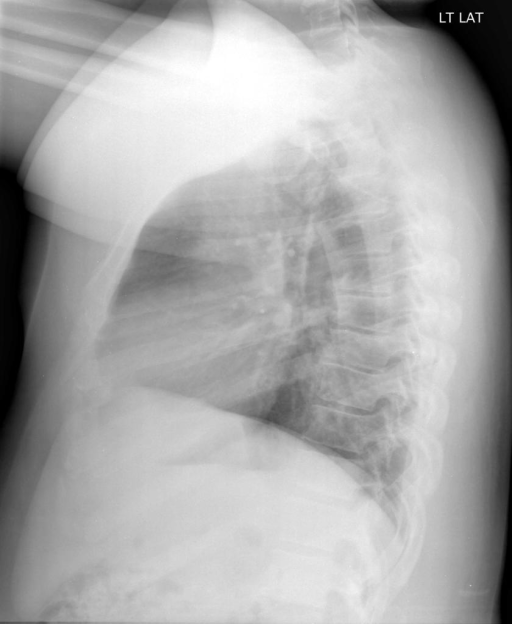

In [8]:
# An example of a radiology image that is normal
from PIL import Image
from IPython.display import display

# Load image from file
normal = images_df[images_df['label']=='normal'].sample(1).iloc[0]
image_path = normal['image_id']
image = Image.open(image_path)
impression = reports_df[reports_df['id']==normal['id']]['impression'].iloc[0]
print('Impression:',impression)

# Display the image
display(image)

Impression: Cardiomegaly with interstitial edema. No effusions, pneumonia, nodules or masses.


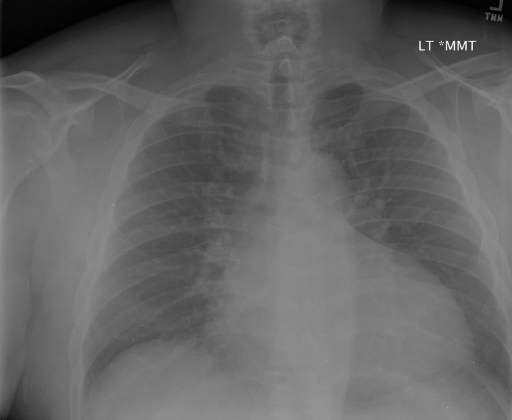

In [9]:
# An example of a radiology image that is abnormal

# Load image from file
abnormal = images_df[images_df['label']=='abnormal'].sample(1).iloc[0]
image_path = abnormal['image_id']
image = Image.open(image_path)
impression = reports_df[reports_df['id']==abnormal['id']]['impression'].iloc[0]
print('Impression:',impression)

# Display the image
display(image)

Abnormal: 2469
Normal: 1486


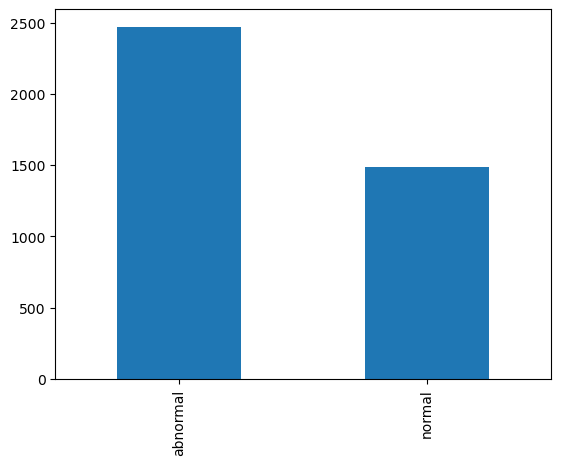

In [10]:
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
label_counts.plot.bar();

In [11]:
reports_df.to_csv('reports_df.csv')
images_df.to_csv('images_df.csv')

## Train Test Split

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2021)

train_df, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)

## Preprocess

In [23]:
import scispacy
import spacy
from negspacy.negation import Negex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string

nlp = spacy.load("en_core_sci_md")
nlp.add_pipe("negex")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eddieguo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/eddieguo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
from nltk.corpus import stopwords

def preprocess(nlp_model,input_text):
    input_text = input_text.strip()
    doc = nlp_model(input_text)
    negation_list = [0]*len(doc)
    tokens = list()
    stop = set(stopwords.words('english')+list(string.punctuation))
    stop.add("XXXX")
    
    for ent in doc.ents:
        if ent._.negex:
            index = ent.start
            while index < ent.end:
                negation_list[index] = 1
                index += 1
        
    for i,token in enumerate(doc):
        if str(token).lower() not in stop:
            if negation_list[i] == 1:
                tokens.append(("NEGEX_"+str(token).lower()))
            else:
                tokens.append(str(token).lower())

    return tokens

In [25]:
from gensim.corpora import Dictionary

train_text = train_df["full-text"].to_list()

def token_generator(text_list):
    for text in text_list:
        yield preprocess(nlp,text)

train_tokens = token_generator(train_text)
train_vocab_dict = Dictionary(train_tokens)

# gensim Dictionary does not create an id2token dictionary  until dictionary is called
train_vocab_dict[0]

'NEGEX_acute'

In [26]:
test_text = test_df["full-text"].to_list()
test_tokens = token_generator(test_text)

## Modeling - Naive Bayes

In [27]:
y_train = list(map(int,(train_df['label'] != "normal").to_list()))
y_test = list(map(int,(test_df['label'] != "normal").to_list()))

In [28]:
def sparse_vector_create(tuple_list,vocab_len):
    #tuple_list will have data structure akin to gensim dictionary doc2bow output 
    sparse_vector = np.zeros(vocab_len)
    for id,freq in tuple_list:
        sparse_vector[id] = freq
    return sparse_vector

def sparse_vector_generator(tokens,vocab_dict,vocab_len):
    for token in tokens:
        yield sparse_vector_create(vocab_dict.doc2bow(token),vocab_len)

# recreate generator object to reset it , otherwise will output empty result
train_tokens = token_generator(train_text)
x_train_sparse = [sparse_vector for sparse_vector in sparse_vector_generator(train_tokens,train_vocab_dict,len(train_vocab_dict))]

In [29]:
from sklearn import naive_bayes

nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

nb_classifier.fit(x_train_sparse,y_train)

MultinomialNB()

In [30]:
test_tokens = token_generator(test_text)
nb_predictions = list()

for token in test_tokens:
    test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
    nb_predictions.append(nb_classifier.predict(test_sparse_vector.reshape(1,-1))[0])

## Modeling - Support Vector Machine (SVM)

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, smooth_idf = True,sublinear_tf = True)
tfidf.fit(x_train_sparse)
x_train_tfidf= tfidf.transform(x_train_sparse)

In [32]:
from sklearn import svm

SVM = svm.SVC(C=1.0,kernel ='linear')
SVM.fit(x_train_tfidf,y_train)

SVC(kernel='linear')

In [33]:
test_tokens = token_generator(test_text)
svm_predictions = list()

for token in test_tokens:
    test_sparse_vector = sparse_vector_create(train_vocab_dict.doc2bow(token),len(train_vocab_dict))
    x_test_tfidf = tfidf.transform(test_sparse_vector.reshape(1,-1))
    svm_predictions.append(SVM.predict(x_test_tfidf)[0])

In [34]:
from sklearn import metrics

class metric_calc:
    def __init__(self, y,y_hat):
        # y is true label, y_hat is predicted label
        self.y_hat = y_hat
        self.y = y
        conf_matrix = metrics.confusion_matrix(y,y_hat)
    
        self.true_neg = conf_matrix[0][0]
        self.false_pos = conf_matrix[0][1]
        self.false_neg = conf_matrix[1][0]
        self.true_pos = conf_matrix[1][1]

    def conf_matrix_values(self):
        print(f"TN: {self.true_neg}, FP: {self.false_pos}, FN: {self.false_neg} TP: {self.true_pos}")

    def sens_spec(self):
        sens = self.true_pos/(self.true_pos+self.false_neg)
        spec = self.true_neg/(self.true_neg+self.false_pos)
        print(f"Sensitivity (aka recall) is {sens:.4f}")
        print(f"Specificity is {spec:.4f}")

    def incorrect_index(self):
        # return indices of examples that are incorrectly predicted
        index = list()
        for i,label in enumerate(self.y):
            if label != self.y_hat[i]:
                index.append(i)
        return index

In [35]:
print("Naive Bayes")
nb_metric = metric_calc(y_test,nb_predictions)
nb_metric.conf_matrix_values()
nb_metric.sens_spec()

print("SVM")
svm_metric = metric_calc(y_test,svm_predictions)
svm_metric.conf_matrix_values()
svm_metric.sens_spec()

Naive Bayes
TN: 209, FP: 14, FN: 44 TP: 327
Sensitivity (aka recall) is 0.8814
Specificity is 0.9372
SVM
TN: 208, FP: 15, FN: 5 TP: 366
Sensitivity (aka recall) is 0.9865
Specificity is 0.9327
